<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/APIs/2_APIs_Series_Tiempo/clase-2.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>
<div align="center"> Recordá abrir en una nueva pestaña </div>

# APIs de Series de Tiempo 

Esta clase presume un conocimiento basico de lo que es una API rest, del uso de la libreria `requests` y de `pandas`. Para una breve introduccion a APIs REST se recomienda revisar primero la [clase 1 de APIs](https://github.com/institutohumai/cursos-python/tree/master/APIs/1_APIs_Geograficas).

La siguiente celda se usa para instalar en el entorno de ejecucion librerias que no vienen pre instaladas en Google Colab.

In [1]:
!pip install markdown
!pip install pdfkit
!pip install requests
!pip install arrow

Looking in indexes: https://nexus.corp.indeed.com/repository/pypi/simple
Looking in indexes: https://nexus.corp.indeed.com/repository/pypi/simple
Looking in indexes: https://nexus.corp.indeed.com/repository/pypi/simple
Looking in indexes: https://nexus.corp.indeed.com/repository/pypi/simple


In [2]:
import requests
import pandas as pd
import arrow
import json

# nos serviran para generar PDFs
import markdown
import pdfkit

# permite que los gráficos se vean directamente en el notebook
%matplotlib inline 

# aplica una hoja de estilos para los gráficos
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# establece un alto y ancho default para todos los graficos
plt.rcParams['figure.figsize'] = (12, 8)

## Series de tiempo

Las series de tiempo son datos estructurados en forma tal que existe una **variable numérica que evoluciona en el tiempo, a intervalos regulares**.

El PBI, la inflación, las exportaciones, la temperatura, la cantidad de llamadas a un call center... son todas variables que se pueden tratar como series de tiempo. Lo distintivo de esta estructura de datos es que tiene una sola dimension de apertura que configura su indice o clave primaria (aquella que permite devolver una sola fila de la tabla): **el tiempo**.

## API Series de Tiempo

La **[API Series de Tiempo de la Republica Argentina](https://apis.datos.gob.ar/series)** es una API REST desarrollada y mantenida por el Estado Nacional de Argentina para la consulta de estadisticas en formato de series de tiempo. Contiene mas de 25 mil series publicadas por mas de 10 organismos publicos, tanto de series historicas como actualizadas.

La API permite:

* [Buscar series](https://datosgobar.github.io/series-tiempo-ar-api/reference/search-reference/) por texto. Tambien se pueden buscar en el sitio web de datos.gob.ar: https://datos.gob.ar/series
* Cambiar la frecuencia (por ejemplo: convertir series diarias en mensuales)
* Elegir la funcion de agregacion de valores, usada en el cambio de frecuencia (una serie se puede convertir de diaria a mensual promediando, sumando, sacando el maximo, el minimo, el ultimo valor del periodo, etc).
* Filtrar por rango de fechas
* Elegir el formato (CSV o JSON)
* Cambiar configuracion del CSV (caracter separador, caracter decimal)

En https://datos.gob.ar/series podés buscar series de tiempo publicadas por distintos organismos de la Administración Pública Nacional en Argentina y usar el link al CSV para leerlos directamente desde python con pandas.

Tambien podes **buscar los ids de las series de interes** y juntarlos en la misma consulta para armar una tabla de hasta 40 series.

En esta clase vamos a ver como se usa, y algunos ejemplos de cosas utiles que podes hacer con ella en python.

### Parametros del recurso `/series` 

La llamada a la API de series tiene la misma estructura que el sitio web de busqueda y consulta. El unico parametro obligatorio es `ids`, que debe contener los ids de 1 o mas series separados con comas.

Por ejemplo: 

* URL web: https://datos.gob.ar/series/api/series/?ids=105.1_I2P_2016_M_13,105.1_I2CPC_2016_M_27 Desde esta UI web podés copiar la URL a un archivo CSV o JSON que tiene la evolución del precio de la papa y de la picada común 
* URL API en CSV: https://apis.datos.gob.ar/series/api/series/?ids=105.1_I2P_2016_M_13,105.1_I2CPC_2016_M_27&limit=5000&format=csv
* URL API en JSON: https://apis.datos.gob.ar/series/api/series/?ids=105.1_I2P_2016_M_13,105.1_I2CPC_2016_M_27&limit=5000&format=json

Como podes ver, la URL es practicamente igual agregando `apis` al principio, y especificando el formato en el que se desea la respuesta.

En pandas podes leer directamente la URL en CSV.

In [3]:
df = pd.read_csv("https://apis.datos.gob.ar/series/api/series/?ids=105.1_I2P_2016_M_13,105.1_I2CPC_2016_M_27&limit=5000&format=csv")

In [4]:
df.tail()

,indice_tiempo,ipc_2016_papa,ipc_2016_carne_picada_comun
47,2020-03-01,32.84,214.88
48,2020-04-01,36.65,227.42
49,2020-05-01,34.58,229.53
50,2020-06-01,33.85,230.34
51,2020-07-01,36.48,235.95


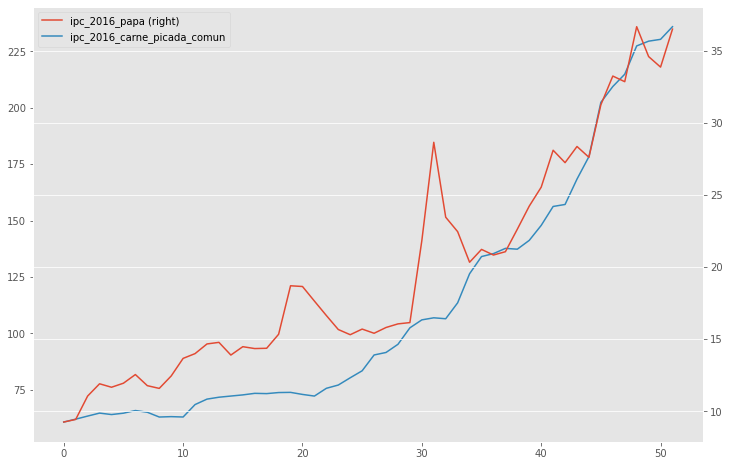

In [5]:
df.plot(secondary_y="ipc_2016_papa")

#### Frecuencia (`collapse` y `collapse_aggregation`)

La API automaticamente elige la frecuencia de mayor desagregacion temporal posible (la frecuencia mas alta), dadas las series solicitadas. Si en la misma llamada se solicita una serie diaria y una mensual, la mayor frecuencia posible es mensual.

Vamos a guardar la base de la llamada a la API para facilitar las cosas. Para estos ejemplos, siempre vamos a querer usar `format=csv` y `last=5000` (la API no devuelve *todos* los valores disponibles por default, `limit` permite elegir hasta los primeros 5000 valores y `last` permite elegir hasta los ultimos 5000 valores).

In [6]:
BASE_API = 'https://apis.datos.gob.ar/series/api/series/?format=csv&last=5000'

**Tipo de cambio del Banco Nacion (canal electronico, venta, valor de cierre a las 15hs)**. Serie diaria.

https://datos.gob.ar/series/api/series/?ids=tc_usd_bna_ev15

In [7]:
tc_bna_id = "tc_usd_bna_ev15"
tc_bna_api = f"{BASE_API}&ids={tc_bna_id}"

**Nota**: si no lo usaste antes, desde la version 3.7 de python se pueden pasar variables directamente en un string de python usando la `f` al principio y los `{}` para separar lo que es codigo, de lo que es texto.

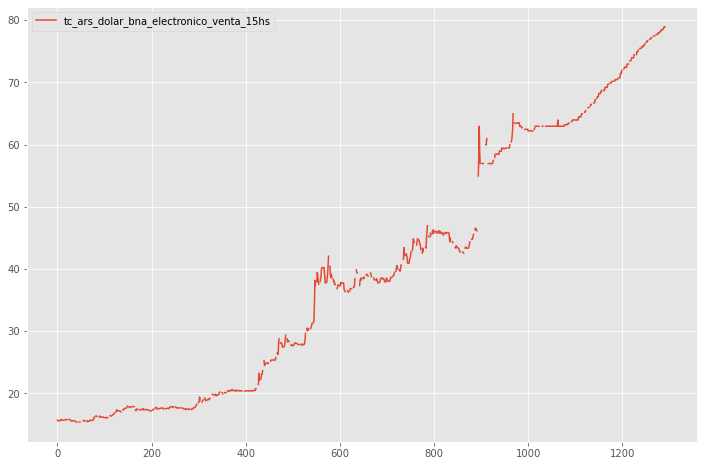

In [8]:
pd.read_csv(tc_bna_api).plot()

Podemos adivinar que la seri

**Precio del kilo de picada comun**. Serie mensual.

https://datos.gob.ar/series/api/series/?ids=105.1_I2CPC_2016_M_27

In [9]:
picada_id = "105.1_I2CPC_2016_M_27"
picada_api = f"{BASE_API}&ids={picada_id}"

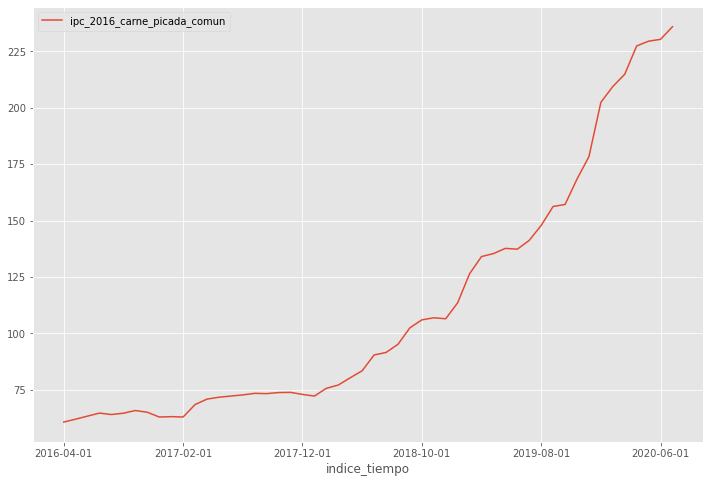

In [10]:
pd.read_csv(picada_api).set_index('indice_tiempo').plot()

Ahora tratemos de juntar las dos series en la misma llamada, y veamos que pasa.

In [11]:
tc_picada_api = f"{BASE_API}&ids={tc_bna_id},{picada_id}"

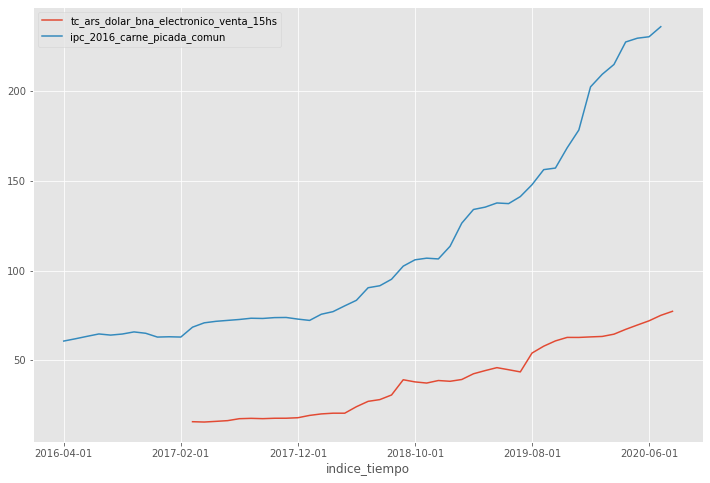

In [12]:
pd.read_csv(tc_picada_api).set_index('indice_tiempo').plot()

La API convirtio la serie de tipo de cambio en **mensual** y aplico un **promedio**, para poder tener las dos series en la misma tabla.

El parametro `collapse` aplicado a esta consulta nos permite ir hacia frecuencias mas bajas, pero nunca mas altas. Las frecuencias disponibles son:

* `year`: Muestra datos agregados anualmente.
* `semester`: Muestra datos agregados semestralmente.
* `quarter`: Muestra datos agregados trimestralmente.
* `month`: Muestra datos agregados mensualmente.
* `week`: Muestra datos agregados semanalmente.
* `day`: Muestra datos agregados diariamente.

In [13]:
tc_picada_q_api = f"{BASE_API}&ids={tc_bna_id},{picada_id}&collapse=quarter"

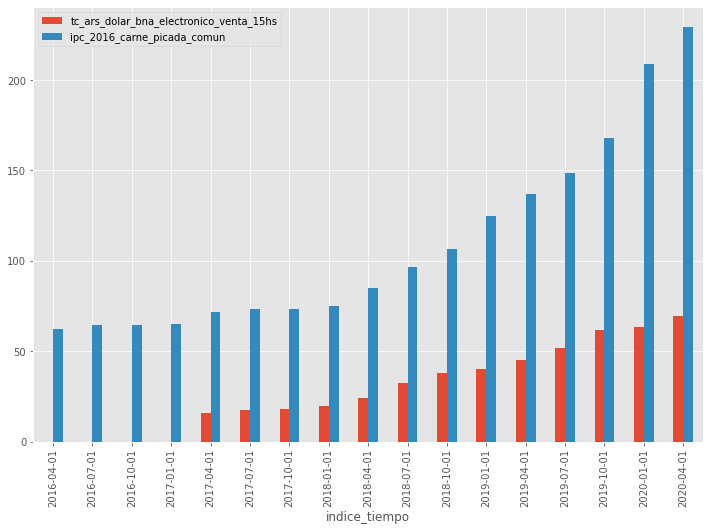

In [14]:
pd.read_csv(tc_picada_q_api).set_index('indice_tiempo').plot(kind='bar')

Tambien podemos cambiar la funcion que se usa para agregar datos temporalmente, con `collapse_aggregation`. Las funciones disponibles son:

* `avg`: Realiza el promedio de todos los valores agrupados. Es la opción por defecto si no se indica valor para collapse_aggregation.
* `sum`: Suma todos los valores agrupados.
* `end_of_period`: Último valor del período.
* `min`: Mínimo entre los valores agrupados.
* `max`: Máximo entre los valores agrupados.

In [15]:
tc_bna_api = f"{BASE_API}&ids={tc_bna_id}&collapse=month&collapse_aggregation=end_of_period"

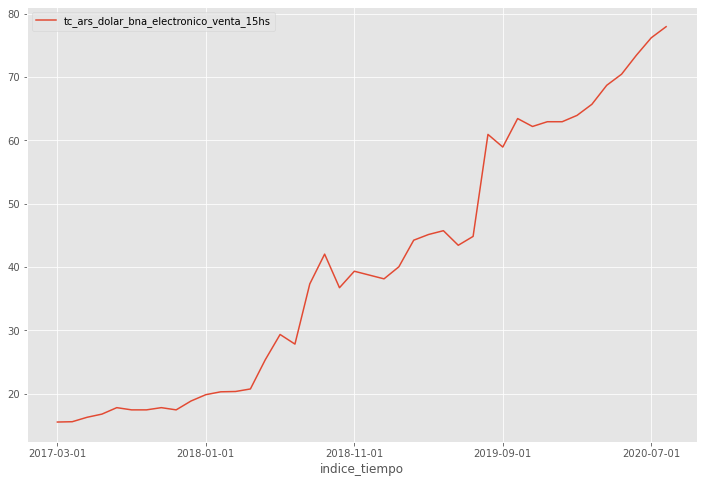

In [16]:
pd.read_csv(tc_bna_api).set_index('indice_tiempo').plot()

Ese grafico muestra los valores de cierre de cada mes, para el tipo de cambio del Banco Nacion. Pero commo hacemos para tener en un mismo grafico los minimos, maximos y promedios mensuales del tipo de cambio?

El parametro `collapse_aggregation` se puede usar en forma individual para cada serie, y las series se pueden repetir en la misma llamada.

In [17]:
tc_bna_api = f"{BASE_API}&ids={tc_bna_id}:min,{tc_bna_id}:avg,{tc_bna_id}:max&collapse=month"

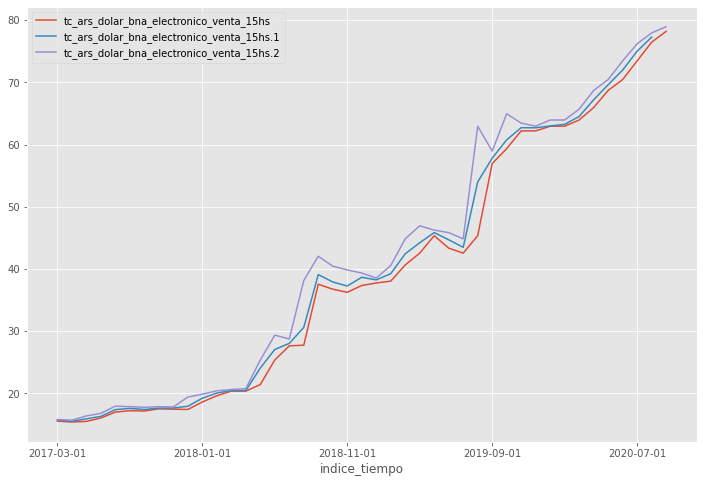

In [18]:
pd.read_csv(tc_bna_api).set_index('indice_tiempo').plot()

En este caso probablemente convenga cambiar los nombres de las columnas, hacia algo un poco mas claro.

In [19]:
df_tc_bna = pd.read_csv(
    tc_bna_api, 
    # elige nombres nuevos para las columnas
    names=['indice_tiempo', 'minimo', 'promedio', 'maximo'],
    # saltea la primer fila, que contiene los otros nombres
    skiprows=1,
).set_index('indice_tiempo')

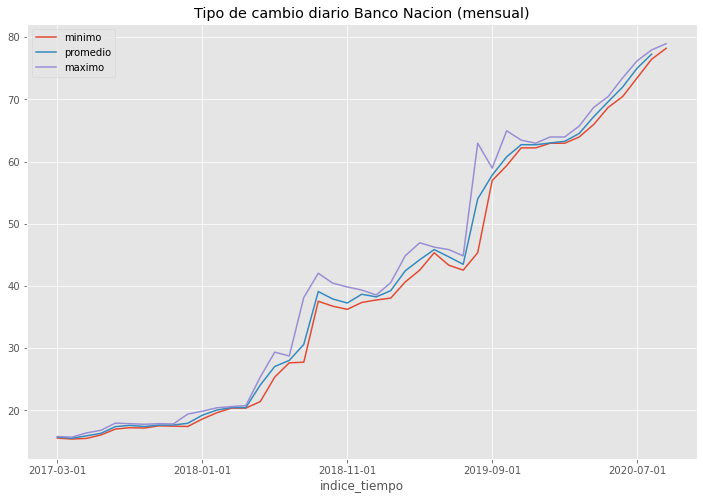

In [20]:
df_tc_bna.plot(
    title="Tipo de cambio diario Banco Nacion (mensual)"
)

**Ejercicio:** realiza un grafico similar al del tipo de cambio, con las temperaturas diarias minimas, maximas y promedio por mes. Podes usar alguna de las [series del Servicio Meteorologico Nacional](https://datos.gob.ar/series/api/search/?offset=0&limit=10&catalog_id=smn) para esto. La estacion de Aeroparque sirve como referencia de las temperaturas en la Ciudad de Buenos Aires.

#### Modo de representacion (`representation_mode`) 

El parametro `representation_mode` permite aplicar transformaciones a las series. Funciona en forma muy similar al `collapse_aggregation` y tambien se puede aplicar a series individuales usando dos puntos.

Los modos de representación disponibles son:

* `value`: Es el modo de representación por defecto. Devuelve el valor medido en la serie.
* `change`: Devuelve la diferencia absoluta entre el valor del período t y el de t-1.
* `change_a_year_ago`: Devuelve la diferencia absoluta entre el valor del período t y el valor del periodo t, del año anterior.
* `change_since_beginning_of_year`: Devuelve la diferencia absoluta entre el valor del período t y el valor del 1 de enero del año al que pertenece t.
* `percent_change`: Devuelve la variación porcentual entre el valor del período t y el de t-1.
* `percent_change_a_year_ago`: Devuelve la variación porcentual entre el valor del período t y el del período t equivalente de hace un año atrás.
* `percent_change_since_beginning_of_year`: Devuelve la variación porcentual entre el valor del período t y el valor del 1 de enero del año al que pertenece t.

Esto nos podria servir, por ejemplo, para comparar el ritmo de aumento de la carne picada comun con el del nivel general de precios de la economia.

Sin embargo aca conviene no usar el parametro `last`, para tener los calculos hasta los valores mas actualizados (este parametro no funciona bien en combinacion con `representation_mode`).

In [21]:
BASE_API = 'https://apis.datos.gob.ar/series/api/series/?format=csv&limit=5000'

In [22]:
ipc_id = '148.3_INIVELNAL_DICI_M_26'
inflacion_picada_api = f"{BASE_API}&ids={picada_id},{ipc_id}&representation_mode=percent_change_a_year_ago"

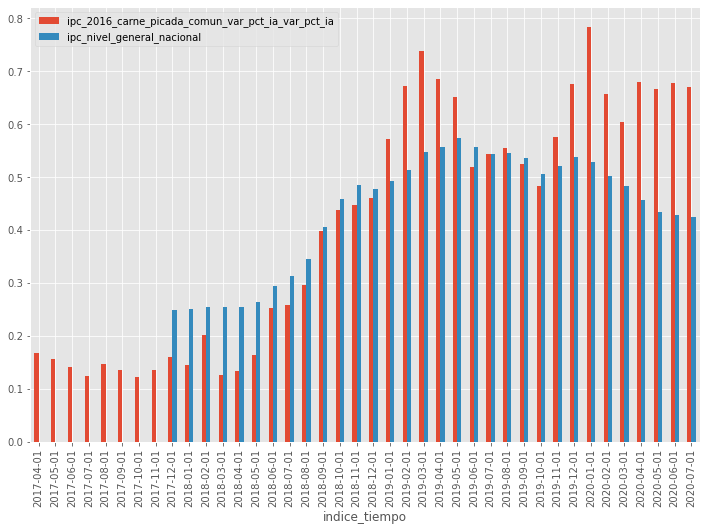

In [23]:
pd.read_csv(inflacion_picada_api).set_index('indice_tiempo').plot(kind='bar')

**Ejercicio:** hacer un grafico donde se compare el ritmo de crecimiento interanual de los precios de 3 productos diferentes. Podes buscar los ids en la distribucion de [precios de referencia del IPC GBA](https://datos.gob.ar/dataset/sspm-indice-precios-al-consumidor-nacional-ipc-base-diciembre-2016/archivo/sspm_145.13).

**Ejercicio:** hacer una tabla (un dataframe) con las variaciones porcentuales mensuales e interanuales del IPC general de las distintas regiones del pais. Podes buscar los ids [en esta distribucion](https://datos.gob.ar/dataset/sspm-indice-precios-al-consumidor-nacional-ipc-base-diciembre-2016/archivo/sspm_145.9).

#### Filtros por fechas (`start_date` y `end_date`) 

Los parametros `start_date` y `end_date` permiten filtrar por rango de tiempo. Siempre deben usarse respetando el formato ISO 8601 para las fechas, utilizando solo la parte de la fecha y no la de la hora:

`YYYY-MM-DD`

Se puede usar completa, o solo la parte relevante. Ejemplo:

* "2020" filtrara todos los valores que sean anteriores al 2020-01-01
* "2020-03" filtrara todos los valores que sean anteriores al 2020-03-01
* "2020-03-28" filtrara todos los valores que sean anteriores al 2020-03-28

In [24]:
tc_bna_api = f"{BASE_API}&ids={tc_bna_id}&collapse=month&start_date=2020"

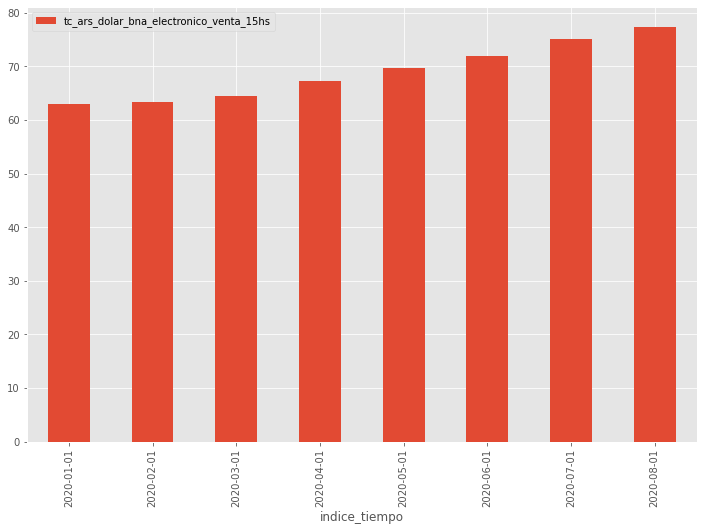

In [25]:
pd.read_csv(tc_bna_api).set_index('indice_tiempo').plot(kind='bar')

Serie diaria desde marzo de 2020.

In [26]:
tc_bna_api = f"{BASE_API}&ids={tc_bna_id}&start_date=2020-03"

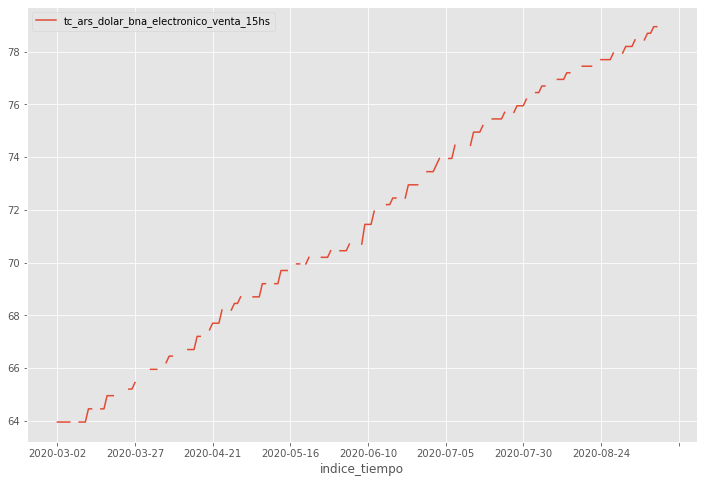

In [27]:
pd.read_csv(tc_bna_api).set_index('indice_tiempo').plot()

**Ejercicio:** hacer un grafico del valor del kilo de pan frances desde el comienzo de la cuarentena en Argentina, junto con el indice general de inflacion en un eje secundario.

### Ejemplo de uso 1: analisis de correlacion con el EMAE

Ahora vamos a usar algunas series de la API para usar algunas funcionalidades de `pandas` muy frecuentemente utilizadas cuando se trabaja con series de tiempo. Para esto vamos usar algunas series del Estimador Mensual de Actividad Economica (EMAE).

In [28]:
# tomamos los datos del Estimador Mensual de la Actividad Económica
emae = pd.read_csv(
    f"{BASE_API}&ids=143.3_NO_PR_2004_A_31,143.3_NO_PR_2004_A_28,143.3_NO_PR_2004_A_21"
).set_index('indice_tiempo')

In [29]:
# para ver las últimas filas
emae.tail(10)

,emae_desestacionalizada,emae_tendencia_ciclo,emae_original
indice_tiempo,,,
2019-09-01,142.277423,142.092375,135.057471
2019-10-01,143.525550,141.848306,142.240648
2019-11-01,141.767174,141.563450,138.158557
2019-12-01,141.626587,141.255951,135.445432
2020-01-01,141.212241,140.944043,131.987520
2020-02-01,140.632007,140.643578,129.369076
2020-03-01,126.237896,140.368520,127.869512
2020-04-01,103.963419,140.128699,110.931869
2020-05-01,114.030034,139.929137,129.448148


Si el objetivo solo fuera tener una rutina para generar la tabla actualizada de las series del EMAE que pueda correr, por ejemplo, todos los dias lunes, desde un dataframe se puede guardar en una variedad de formatos.

In [30]:
emae.to_csv("emae.csv", encoding="utf8")
emae.to_excel("emae.xlsx", encoding="utf8")
emae.to_html("emae.html")
emae.to_stata("emae.dta")

**Ejercicio:** Generar una tabla en Excel o CSV de los tipos de cambio vendedores, canal electronico, valor de cierre a las 15hs, de 3 entidades financieras diferentes. Recuerden que pueden buscar esas series en https://datos.gob.ar/series/api/search/?q=ARS%2FUSD+electronico+venta+15hs&offset=0&limit=10

Si el objetivo es generar un grafico actualizado para poner en un informe

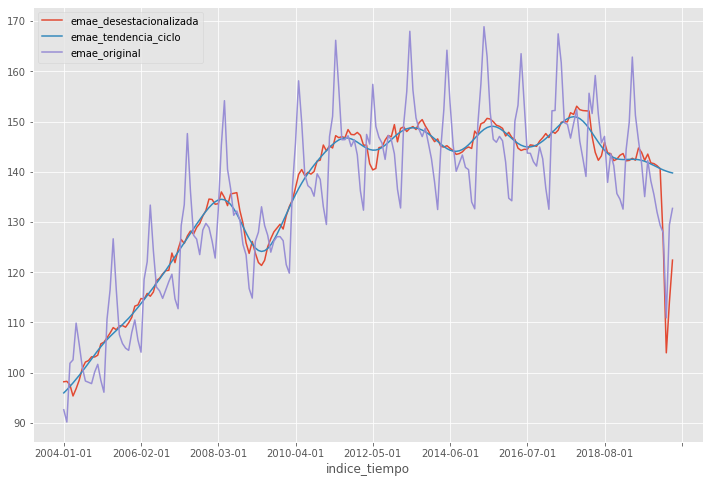

In [31]:
emae.plot()
plt.savefig('emae.png')

**Ejercicio:** hace un grafico de la evolucion del EMAE desde comienzos de 2018 y guardalo en PNG.

Pista: no hace falta que armes una nueva llamada a la API para filtrar por tiempo, podes hacerlo en `pandas`: `emae[emae.index > '2018']`

Como es un grafico mensual, tal vez quieras eliminar el dia del indice. Podes conseguir esto convirtiendo los valores del indice a "periodos" en `pandas`. 

Para esto primero tenemos que convertir el tipo del indice de "texto" a "fecha".

In [32]:
emae.index = pd.to_datetime(emae.index)
emae.index = emae.index.to_period()

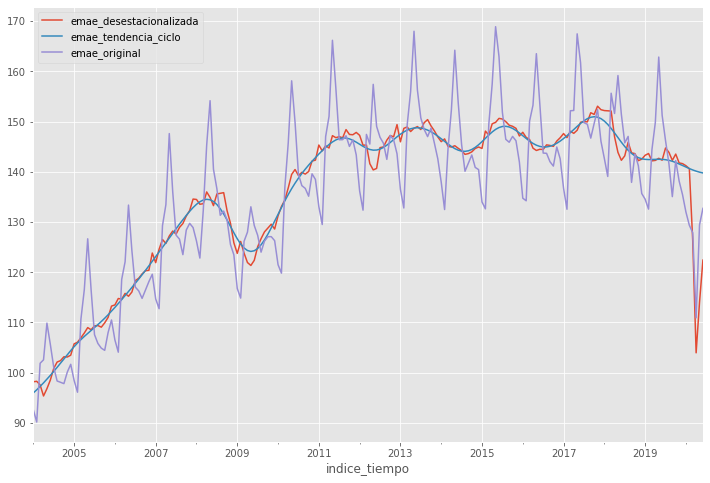

In [33]:
emae.plot()

Pandas automaticamente tratara el indice ofreciendo el detalle mas conveniente para el nivel de zoom aplicado, por eso se ve solo el año en el grafico anterior.

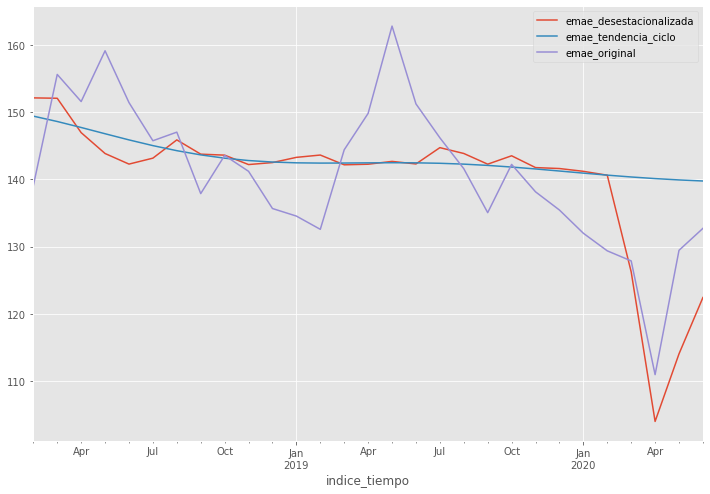

In [34]:
emae[emae.index > '2018'].plot()

Ahora vamos a tratar de analizar la correlacion de distintos sectores de la economia con el nivel de actividad general.

In [35]:
# descargamos el emae general, construcción, industria, comercio, pesca, agricultura y hotelería
nivel_actividad = pd.read_csv(
    f"{BASE_API}&ids=11.3_VMATC_2004_M_12,143.3_NO_PR_2004_A_21,11.3_VMASD_2004_M_23,11.3_VIPAA_2004_M_5,11.3_ISOM_2004_M_39,11.3_P_2004_M_20,11.3_AGCS_2004_M_41"
).set_index('indice_tiempo')

# generamos el índice de tiempo
nivel_actividad.index = pd.to_datetime(nivel_actividad.index)

In [36]:
nivel_actividad.tail()

,construccion,emae_original,industria_manufacturera,pesca,agricultura_ganaderia_caza_silvicultura,hoteles_restaurantes,comercio_mayorista_minorista_reparaciones
indice_tiempo,,,,,,,
2020-02-01,127.601879,129.369076,102.487593,162.063730,78.593601,168.668537,129.143309
2020-03-01,86.299511,127.869512,96.988588,77.939813,141.634594,104.548054,130.475126
2020-04-01,19.629258,110.931869,76.909105,124.102878,211.379770,23.047304,98.554211
2020-05-01,57.068012,129.448148,92.280154,148.763043,291.163703,42.378345,117.173151
2020-06-01,79.549698,132.717002,113.095569,83.910534,205.389498,56.845209,143.012271


El metodo `plot` de un dataframe permite hacer distintos graficos, tanto usando el parametro `kind=bar` como accediendo al tipo de grafico a traves de un punto.

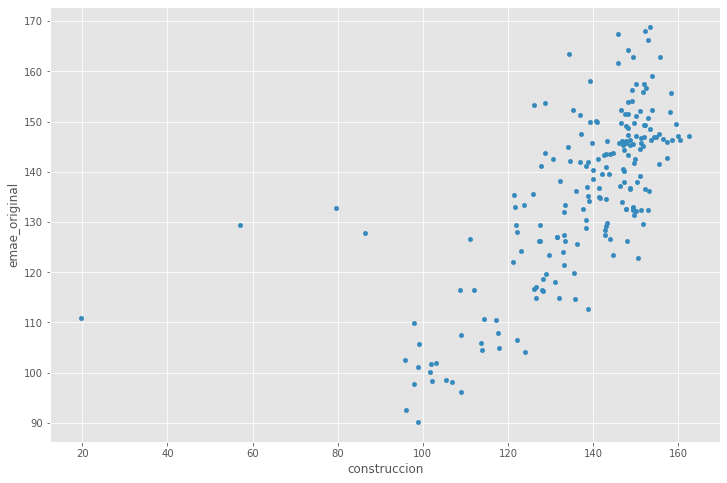

In [37]:
nivel_actividad.plot.scatter("construccion", "emae_original")

Con `matplotlib` podemos hacer multiples graficos en uno solo, con la funcion `plt.subplots()`.

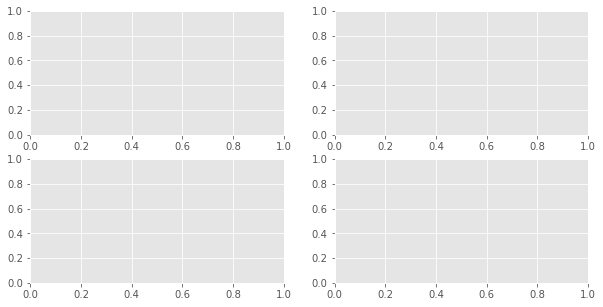

In [38]:
# genera un lienzo con 4 subgráficos vacíos
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

Dentro de la misma celda donde se crea el lienzo de subgráficos, deben crearse y asignarse a los "axes" (ejes) c/u de los subgráficos.

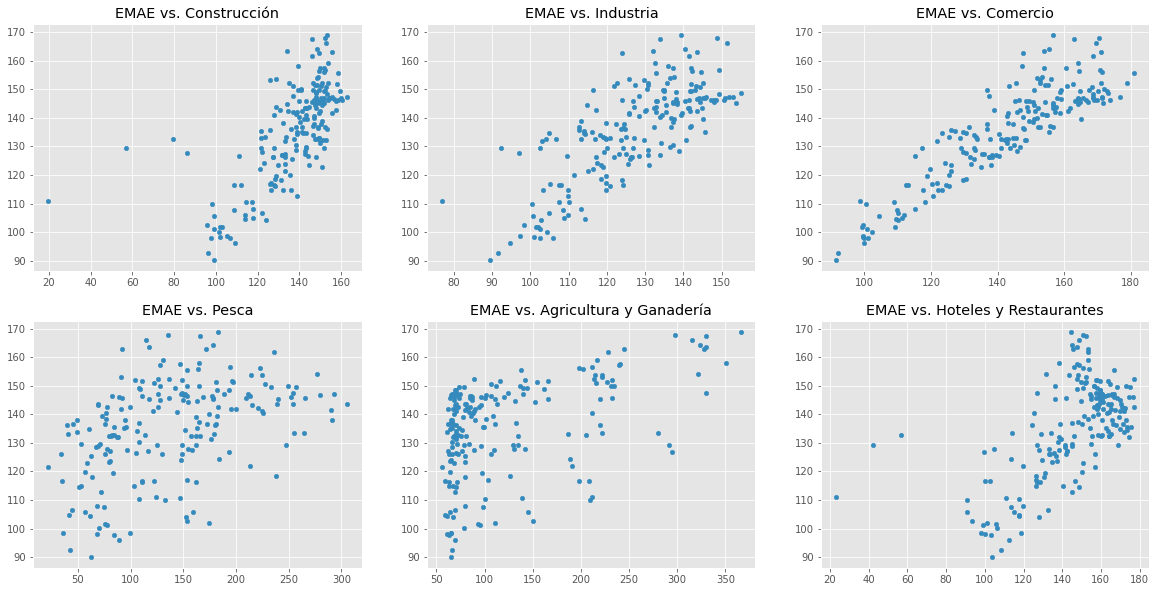

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# graficos de la fila 1
nivel_actividad.plot.scatter("construccion", "emae_original", 
                             ax=axes[0,0], title="EMAE vs. Construcción")
nivel_actividad.plot.scatter("industria_manufacturera", "emae_original", 
                             ax=axes[0,1], title="EMAE vs. Industria")
nivel_actividad.plot.scatter("comercio_mayorista_minorista_reparaciones", "emae_original",
                             ax=axes[0,2], title="EMAE vs. Comercio")

# graficos de la fila 2
nivel_actividad.plot.scatter("pesca", "emae_original", ax=axes[1,0], 
                             title="EMAE vs. Pesca")
nivel_actividad.plot.scatter("agricultura_ganaderia_caza_silvicultura", "emae_original", 
                             ax=axes[1,1], title="EMAE vs. Agricultura y Ganadería")
nivel_actividad.plot.scatter("hoteles_restaurantes", "emae_original", 
                             ax=axes[1,2], title="EMAE vs. Hoteles y Restaurantes")

# elimina los labels de los ejes para que se vea mejor
for row in axes:
    for ax in row:
        pass
        ax.set_xlabel("")
        ax.set_ylabel("")

La construcción, la industria, el comercio y los servicios de hotelería y restaurantes parecen correlacionar fuertemente con el nivel de actividad general, mientras que la pesca y el sector agropecuario casi no muestran relación alguna! Podés mirar la matriz de correlaciones de la tabla para corroborar esto.

In [40]:
nivel_actividad.corr()

,construccion,emae_original,industria_manufacturera,pesca,agricultura_ganaderia_caza_silvicultura,hoteles_restaurantes,comercio_mayorista_minorista_reparaciones
construccion,1.000000,0.694427,0.770678,0.268925,-0.062003,0.838482,0.779643
emae_original,0.694427,1.000000,0.768573,0.439108,0.456038,0.623531,0.893406
industria_manufacturera,0.770678,0.768573,1.000000,0.338224,0.089081,0.582126,0.907659
pesca,0.268925,0.439108,0.338224,1.000000,0.278565,0.163865,0.379686
agricultura_ganaderia_caza_silvicultura,-0.062003,0.456038,0.089081,0.278565,1.000000,-0.257161,0.139429
hoteles_restaurantes,0.838482,0.623531,0.582126,0.163865,-0.257161,1.000000,0.669669
comercio_mayorista_minorista_reparaciones,0.779643,0.893406,0.907659,0.379686,0.139429,0.669669,1.000000


Si ves la pesca y el sector agropecuario en el mismo gráfico con la serie original, es evidente que estos dos sectores tienen una estacionalidad mucho más pronunciada que el nivel general de actividad, esto puede explicar en parte que tengan una baja correlación.

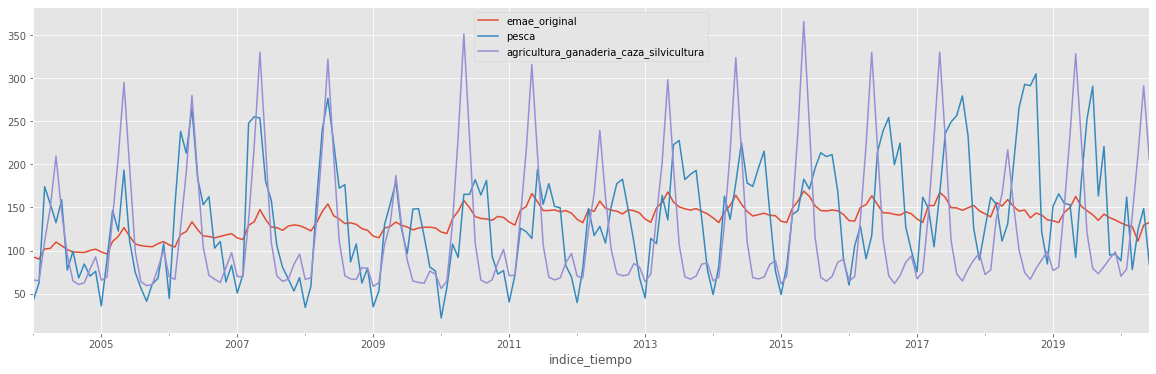

In [41]:
nivel_actividad[
    ["emae_original", "pesca", "agricultura_ganaderia_caza_silvicultura"]
].plot(figsize=(20, 6))

Probablemente debas chequear si existe relación cuando se consideran las variaciones del índice, en lugar del valor absoluto. 

Pero el bloque de código para generar los graficos multiples es bastante engorroso para estar probando ágilmente esas transformaciones y cambiar rápidamente lo que vemos.

**Deberíamos poner ese bloque dentro de una función, cuyos argumentos de entrada sean aquellas cosas que quieras cambiar.**

In [42]:
def generate_emae_scatters(nivel_actividad):
    """Grafica el scatter de 6 sectores vs. el nivel general de actividad."""
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

    # graficos de la fila 1
    nivel_actividad.plot.scatter("construccion", "emae_original", 
                                 ax=axes[0,0], title="EMAE vs. Construcción")
    nivel_actividad.plot.scatter("industria_manufacturera", "emae_original", 
                                 ax=axes[0,1], title="EMAE vs. Industria")
    nivel_actividad.plot.scatter("comercio_mayorista_minorista_reparaciones", "emae_original",
                                 ax=axes[0,2], title="EMAE vs. Comercio")

    # graficos de la fila 2
    nivel_actividad.plot.scatter("pesca", "emae_original", ax=axes[1,0], 
                                 title="EMAE vs. Pesca")
    nivel_actividad.plot.scatter("agricultura_ganaderia_caza_silvicultura", "emae_original", 
                                 ax=axes[1,1], title="EMAE vs. Agricultura y Ganadería")
    nivel_actividad.plot.scatter("hoteles_restaurantes", "emae_original", 
                                 ax=axes[1,2], title="EMAE vs. Hoteles y Restaurantes")

    # elimina los labels de los ejes para que se vea mejor
    for row in axes:
        for ax in row:
            pass
            ax.set_xlabel("")
            ax.set_ylabel("")
    
    return axes

**Ejercicio:** usa la funcion para graficar las correlaciones entre los % de variacion contra el periodo anterior.

Pista: en pandas podes agregar un `.pct_change(1)` para convertir todos los valores a % de variacion respecto del valor anterior. Que crees que pasara si repetis los graficos con `.pct_change(2)`?

Luego de hacer los graficos, calcula tambien la nueva matriz de correlaciones.

Las variaciones en el sector agropecuario casi siempre empujan a las variaciones en el nivel general (que obviamente ocurren en menor magnitud) ya que es un sector con una alta incidencia en la producción total en Argentina. No es este el caso de la pesca.

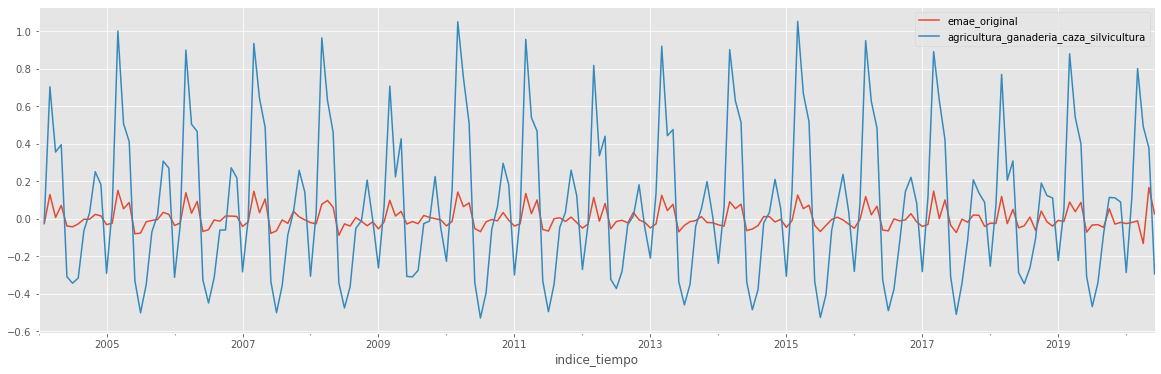

In [43]:
nivel_actividad.pct_change(1)[
    ["emae_original", "agricultura_ganaderia_caza_silvicultura"]
].plot(figsize=(20, 6))

Si querés seguir la evolución de mediano plazo de la producción agropecuaria, una forma sencilla de remover el ruido estacional es aplicar un promedio móvil de 12 meses.

Para esto podés usar la función `rolling` que te permite elegir una ventana de X períodos sobre la cual hacer un cálculo o una agregación.

In [44]:
nivel_actividad["agri_promedio_movil_12"] = nivel_actividad.agricultura_ganaderia_caza_silvicultura.rolling(12).mean()

Ahora grafiquemos ambas series, con y sin promedio movil.

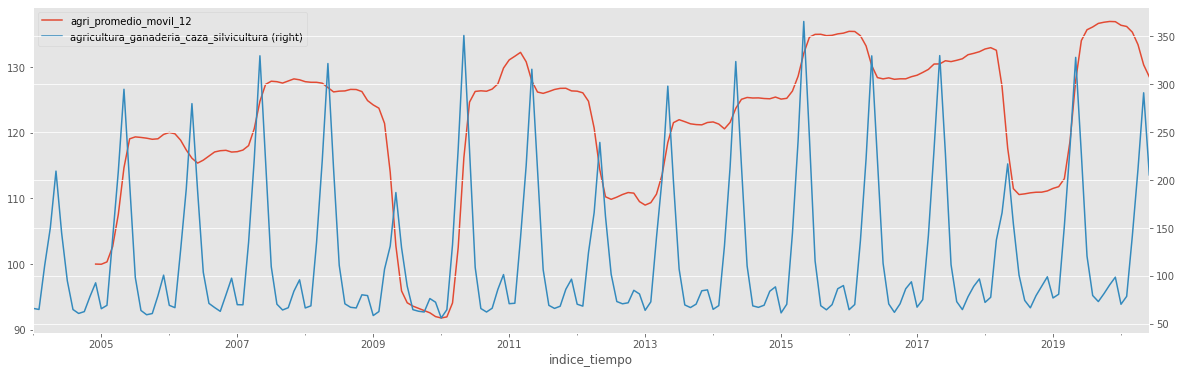

In [45]:
nivel_actividad[
    ["agri_promedio_movil_12", "agricultura_ganaderia_caza_silvicultura"]
].plot(figsize=(20,6), secondary_y="agricultura_ganaderia_caza_silvicultura")

**Ejercicio:** chequear la correlación entre las variaciones interanuales (12 meses) del EMAE y sus componentes sectoriales.

**Ejercicio para hacer en casa:** crear un simple tablero de seguimiento de variables de coyuntura usando subplots que contenga la evolución del tipo de cambio BNA vendedor (promedio móvil 30 días), la tasa de interés de política monetaria, la inflación interanual mensual (pct_change(12), la expectativa de inflación de los próximos 12 meses, las variaciones porcentuales mensuales del nivel de actividad (EMAE) y el saldo comercial mensual (promedio móvil 3 meses).

### Ejemplo de uso 2: generacion de un informe

https://github.com/datosgobar/taller-series-tiempo-mediaparty-2018/blob/master/2A-python.ipynb

Otro uso frecuente es armar reportes que se puedan posteriormente programar y (por ejemplo) enviar por mail automaticamente.

Vamos a ver como hacer esto de una forma sencilla, usando los templates de texto de python , un modulo auxiliar para enviar mails, que esta incluido en este repositorio, y algunas librerias para generar PDFs.

En este caso, posiblemente nos convenga pedir los datos en formato JSON. Tambien queremos hacer un reporte sencillo que solo tenga el ultimo valor conocido de cada variable, y su variacion interanual. 

Asi que vamos a cambiar la llamada base a la API, para pedir solo los valores que necesitamos.

In [46]:
BASE_API = 'https://apis.datos.gob.ar/series/api/series/?format=json&limit=13&sort=desc&collapse=month'

Habras notado que usamos el parametro `sort` para ordenar los resultados en orden descendente (el mas reciente primero). Esto nos va a facilitar seleccionar "el ultimo resultado".

In [47]:
api_call = f"{BASE_API}&ids=168.1_T_CAMBIOR_D_0_0_26:avg,168.1_T_CAMBIOR_D_0_0_26:max,168.1_T_CAMBIOR_D_0_0_26:min"

In [ ]:
requests.get(api_call).json()

La llamada a la API en formato JSON nos devuelve los datos, pero tambien los metadatos. Esto es principalmente util cuando estamos desarrollando aplicaciones web de algun tipo.

Si estamos analizando datos, posiblemente ya hayamos usado los metadatos para elegir las series, pero no los necesitamos mas.

In [49]:
tipo_cambio = requests.get(api_call).json()["data"]

In [50]:
tipo_cambio

[['2020-07-01', 74.9758064516129, 76.25, 73.5],
 ['2020-06-01', 71.98333333333333, 73.5, 70.5],
 ['2020-05-01', 69.69354838709677, 70.5, 68.75],
 ['2020-04-01', 67.13333333333334, 68.75, 66.0],
 ['2020-03-01', 64.66129032258064, 65.75, 64.0],
 ['2020-02-01', 63.310344827586206, 64.0, 63.0],
 ['2020-01-01', 63.0, 63.0, 63.0],
 ['2019-12-01', 62.78225806451613, 63.0, 62.25],
 ['2019-11-01', 62.766666666666666, 63.5, 62.25],
 ['2019-10-01', 60.806451612903224, 65.0, 59.4],
 ['2019-09-01', 58.00833333333333, 61.0, 57.0],
 ['2019-08-01', 53.81612903225806, 63.0, 45.4],
 ['2019-07-01', 43.45161290322582, 44.9, 42.6]]

Ahora vamos a hacer lo mismo con otras variables para nuestro informe.

In [51]:
api_call = f"{BASE_API}&ids=101.1_I2NG_2016_M_22"
ipc = requests.get(api_call).json()["data"]

In [52]:
ipc

[['2020-07-01', 322.6791],
 ['2020-06-01', 317.4661],
 ['2020-05-01', 311.0922],
 ['2020-04-01', 306.4483],
 ['2020-03-01', 302.2274],
 ['2020-02-01', 291.737],
 ['2020-01-01', 286.4913],
 ['2019-12-01', 281.1775],
 ['2019-11-01', 270.8019],
 ['2019-10-01', 260.2101],
 ['2019-09-01', 252.1482],
 ['2019-08-01', 238.3069],
 ['2019-07-01', 229.4286]]

In [53]:
api_call = f"{BASE_API}&ids=143.3_NO_PR_2004_A_21"
emae = requests.get(api_call).json()["data"]

In [54]:
emae

[['2020-06-01', 132.71700174512995],
 ['2020-05-01', 129.4481481382743],
 ['2020-04-01', 110.93186850418589],
 ['2020-03-01', 127.8695117502436],
 ['2020-02-01', 129.36907641347452],
 ['2020-01-01', 131.98752045748455],
 ['2019-12-01', 135.44543162767988],
 ['2019-11-01', 138.15855707957144],
 ['2019-10-01', 142.24064825618933],
 ['2019-09-01', 135.0574708022306],
 ['2019-08-01', 141.60332874981128],
 ['2019-07-01', 146.2032323361963],
 ['2019-06-01', 151.25410111244764]]

Ahora que tenemos los datos, armemos el reporte!

In [55]:
reporte = """
# Seguimiento de coyuntura

## Tipo de cambio

El tipo de cambio promedio del mes de {mes_tc:%Y-%m} fue {mes_tc_promedio:.2f} con un máximo de {mes_tc_max:.2f} 
y un mínimo de {mes_tc_min:.2f}.

## Inflación

La inflación de {mes_ipc:%Y-%m} respecto de {mes_ipc_anterior:%Y-%m} fue de {mes_ipc_var:.2%}, mientras que la inflación interanual
{mes_ipc:%Y-%m}/{mes_ipc_anio_anterior:%Y-%m} fue de {mes_ipc_var_interanual:.2%}.

## Nivel de actividad

El EMAE de {mes_emae:%Y-%m} muestra {alza_o_caida_mensual} respecto del mes anterior de {mes_emae_var:.2%}, y un 
{alza_o_caida_interanual} interanual de {mes_emae_var_interanual:.2%}.
""".format(
    
    #tipo de cambio
    mes_tc=arrow.get(tipo_cambio[1][0]).datetime,
    mes_tc_promedio=tipo_cambio[1][1],
    mes_tc_max=tipo_cambio[1][2],
    mes_tc_min=tipo_cambio[1][3],
    
    # ipc
    mes_ipc=arrow.get(ipc[0][0]).datetime,
    mes_ipc_anterior=arrow.get(ipc[1][0]).datetime,
    mes_ipc_var=ipc[0][1]/ipc[1][1] - 1,
    mes_ipc_anio_anterior=arrow.get(ipc[12][0]).datetime,
    mes_ipc_var_interanual=ipc[0][1]/ipc[12][1] - 1,
    
    # emae
    mes_emae=arrow.get(emae[0][0]).datetime,
    alza_o_caida_mensual="alza" if emae[0][1]/emae[1][1]-1 >= 0 else "caída",
    mes_emae_var=emae[0][1]/emae[1][1]-1,
    alza_o_caida_interanual="alza" if emae[0][1]/emae[12][1]-1 >= 0 else "caída",
    mes_emae_var_interanual=emae[0][1]/emae[12][1]-1
)

In [56]:
from IPython.core.display import display, HTML

In [57]:
# genera un HTML a partir del markdown
html = markdown.markdown(reporte)
display(HTML(html))

In [58]:
with open('reporte.html', 'wb') as f:
    f.write(html.encode('utf8'))

Este reporte luego se puede enviar por mail, guardar en PDF u otras cosas que no cubriremos en esta clase.

**Ejercicio para la casa:** agregar las variables Exportaciones e Importaciones al reporte y guardar el HTML.

## API FRED 

Documentacion API: https://fred.stlouisfed.org/docs/api/fred/

La API de FRED ([Federal Reserve Economic Data](https://fred.stlouisfed.org/)) es una API de series de tiempo desarrollada por la sucursal de St. Louis de la Reserva Federal de Estados Unidos.

Tiene mas de 700 mil series de Estados Unidos e internacionales, y es ampliamente utilizada por economistas y otros profesionales que analizan fenomenos economicos. La API de Series de Tiempo de Argentina fue inspirada mayormente en la experiencia previa de FRED.

Su uso requiere registrarse y adquirir un API key, pero es gratuita.

In [59]:
with open('apis_series_creds.json', 'r') as f:
    creds = json.load(f)

In [60]:
fred_key = creds['fred_key']

In [61]:
BASE_FRED_API = 'https://api.stlouisfed.org/fred/'
FRED_SERIES_METADATA = BASE_FRED_API + 'series?series_id={serie_id}&api_key={api_key}&file_type=json'
FRED_SERIES_DATA = BASE_FRED_API + 'series/observations?series_id={serie_id}&api_key={api_key}&file_type=json'

In [62]:
gdp_meta_call = FRED_SERIES_METADATA.format(
    serie_id='GNPCA', api_key=fred_key
)

In [63]:
gdp_metadata = requests.get(gdp_meta_call).json()
gdp_metadata

{'realtime_start': '2020-09-15',
 'realtime_end': '2020-09-15',
 'seriess': [{'id': 'GNPCA',
   'realtime_start': '2020-09-15',
   'realtime_end': '2020-09-15',
   'title': 'Real Gross National Product',
   'observation_start': '1929-01-01',
   'observation_end': '2019-01-01',
   'frequency': 'Annual',
   'frequency_short': 'A',
   'units': 'Billions of Chained 2012 Dollars',
   'units_short': 'Bil. of Chn. 2012 $',
   'seasonal_adjustment': 'Not Seasonally Adjusted',
   'seasonal_adjustment_short': 'NSA',
   'last_updated': '2020-07-30 07:57:33-05',
   'popularity': 18,
   'notes': 'BEA Account Code: A001RX\n\n'}]}

In [64]:
gdp_data_call = FRED_SERIES_DATA.format(
    serie_id='GNPCA', api_key=fred_key
)

In [ ]:
gdp_data = requests.get(gdp_data_call).json()
gdp_data

In [66]:
df_gdp = pd.DataFrame(gdp_data['observations'])
df_gdp

,realtime_start,realtime_end,date,value
0,2020-09-15,2020-09-15,1929-01-01,1120.076
1,2020-09-15,2020-09-15,1930-01-01,1025.091
2,2020-09-15,2020-09-15,1931-01-01,958.378
3,2020-09-15,2020-09-15,1932-01-01,834.291
4,2020-09-15,2020-09-15,1933-01-01,823.156
...,...,...,...,...
86,2020-09-15,2020-09-15,2015-01-01,17647.607
87,2020-09-15,2020-09-15,2016-01-01,17955.437
88,2020-09-15,2020-09-15,2017-01-01,18421.034
89,2020-09-15,2020-09-15,2018-01-01,18951.897


**Ejercicio para la casa**: busca el id de la serie de inflacion en la pagina de FRED, y genera un dataframe de series de tiempo que tenga la siguiente estructura:

* Las fechas (date) deben usarse para construir un indice de tiempo (el index de la tabla).
* Las unicas columnas que debe haber en el dataframe son aquellas que corresponden a cada serie: `pbi_usa`, `ipc_usa`.

## API Quandl 

https://www.quandl.com/tools/api

Quandl ofrece una API de series de tiempo gratuita que contiene numerosos datasets publicos y privados (estos ultimos pagos). Entre ellos, la base completa de FRED es accesible desde la API de Quandl.

La interfaz de la API de Series de Tiempo de Argentina tomo varias ideas de la de Quandl.

In [67]:
BASE_QUANDL_API = 'https://www.quandl.com/api/v3/datasets/'

In [68]:
fred_gdp_call = BASE_QUANDL_API + 'FRED/GDP.csv'
wiki_aapl_call = BASE_QUANDL_API + 'WIKI/AAPL.csv'

In [69]:
df_fred_gdp = pd.read_csv(fred_gdp_call)
df_fred_gdp

,Date,Value
0,2020-04-01,19486.509
1,2020-01-01,21561.139
2,2019-10-01,21747.394
3,2019-07-01,21540.325
4,2019-04-01,21329.877
...,...,...
289,1948-01-01,265.742
290,1947-10-01,259.745
291,1947-07-01,249.585
292,1947-04-01,245.968


In [70]:
df_wiki_aapl = pd.read_csv(wiki_aapl_call)
df_wiki_aapl

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.680000,175.150000,166.920000,168.340000,38962839.0
1,2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.070000,173.100000,166.440000,172.770000,36272617.0
2,2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.390000,169.920000,164.940000,164.940000,40248954.0
3,2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.000000,172.680000,168.600000,168.845000,41051076.0
4,2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.040000,175.090000,171.260000,171.270000,35247358.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9395,1980-12-18,26.63,26.75,26.63,26.630,327900.0,0.0,1.0,0.391536,0.393300,0.391536,0.391536,18362400.0
9396,1980-12-17,25.87,26.00,25.87,25.870,385900.0,0.0,1.0,0.380362,0.382273,0.380362,0.380362,21610400.0
9397,1980-12-16,25.37,25.37,25.25,25.250,472000.0,0.0,1.0,0.373010,0.373010,0.371246,0.371246,26432000.0
9398,1980-12-15,27.38,27.38,27.25,27.250,785200.0,0.0,1.0,0.402563,0.402563,0.400652,0.400652,43971200.0


Algunas de las funcionalidades de filtro y transformacion te van a resultar conocidas!

In [71]:
wiki_aapl_call_transf = BASE_QUANDL_API + 'WIKI/AAPL.csv?column_index=4&start_date=2015-01-01&collapse=monthly'
df_wiki_aapl_transf = pd.read_csv(wiki_aapl_call_transf)
df_wiki_aapl_transf

,Date,Close
0,2018-03-31,168.340
1,2018-02-28,178.120
2,2018-01-31,167.430
3,2017-12-31,169.230
4,2017-11-30,171.850
5,2017-10-31,169.040
6,2017-09-30,154.120
7,2017-08-31,164.000
8,2017-07-31,148.850
9,2017-06-30,144.020


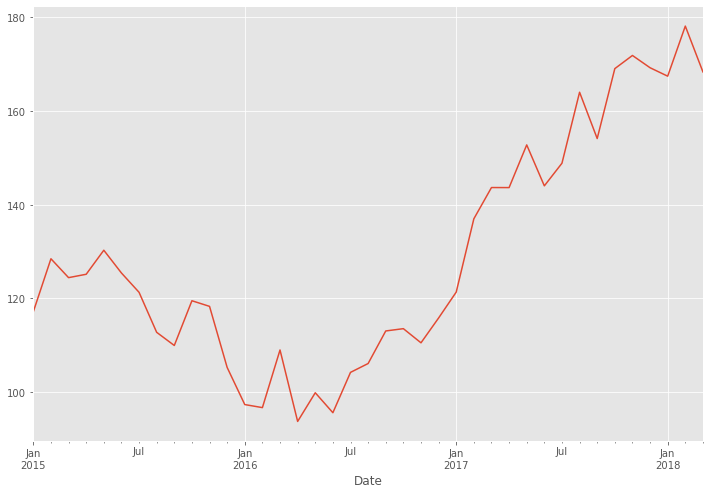

In [72]:
df_wiki_aapl_transf.index = pd.to_datetime(df_wiki_aapl_transf.Date)
df_wiki_aapl_transf.Close.plot()

**Ejercicio para la casa**: generar un dataframe de series de tiempo que tenga las acciones de Apple, Microsoft, Google y Amazon.

**Ejercicio para la casa**: generar un dataframe de series de tiempo con las proyecciones de crecimiento del producto bruto elaboradas por el FMI, para una muestra de paises de Sudamerica. (Dataset del FMI: https://www.quandl.com/data/ODA-IMF-Cross-Country-Macroeconomic-Statistics)

## API Banco Mundial 

Las APIs del Banco Mundial exponen cientos de indicadores de desarrollo de todos los paises del mundo de frecuencia anual, trimestral y mensual.

* Documentacion APIs: https://datahelpdesk.worldbank.org/knowledgebase/topics/125589
* Documentacion API indicadores: https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structures
* Buscar indicadores: https://datos.bancomundial.org/indicator

Ahora vamos a descargar las series por pais de un indicador.

In [210]:
BASE_BM_API = 'http://api.worldbank.org/v2/es/country/{pais}/indicator/{indicador}?format=json&per_page=20000&date=2000:2020'

Notar que la API del BM soporta varios idiomas: en este caso estamos pidiendo los datos en español `v2/es/country`.

Usamos un valor de `per_page` alto para obtener una gran cantidad de resultados sin tener que iterar entre paginas.

Pedimos los resultados para un rango de fechas determinado con `date`, para limitar la cantidad de resultados que se retornan.

Como siempre, fijamos en un template BASE los parametros que siempre vamos a usar para llamar a la API, y dejamos como variables aquellos que vamos a ir cambiando.

In [237]:
# esta llamada pide las exportaciones a USD constantes de 2010, para todos los paises
exportaciones_wb = requests.get(
    BASE_BM_API.format(
        pais='all', 
        indicador='NE.EXP.GNFS.KD'
    )
).json()

In [ ]:
exportaciones_wb

Hay que conseguir leer la estructura de respuesta JSON de forma tal que pueda construirse un DataFrame.

In [215]:
df_expo = pd.DataFrame(exportaciones_wb[1])

In [216]:
df_expo

,indicator,country,countryiso3code,date,value,unit,obs_status,decimal
0,"{'id': 'NE.EXP.GNFS.KD', 'value': 'Exportacion...","{'id': '1A', 'value': 'El mundo árabe'}",ARB,2019,1.387774e+12,,,0
1,"{'id': 'NE.EXP.GNFS.KD', 'value': 'Exportacion...","{'id': '1A', 'value': 'El mundo árabe'}",ARB,2018,1.418474e+12,,,0
2,"{'id': 'NE.EXP.GNFS.KD', 'value': 'Exportacion...","{'id': '1A', 'value': 'El mundo árabe'}",ARB,2017,1.303973e+12,,,0
3,"{'id': 'NE.EXP.GNFS.KD', 'value': 'Exportacion...","{'id': '1A', 'value': 'El mundo árabe'}",ARB,2016,1.273703e+12,,,0
4,"{'id': 'NE.EXP.GNFS.KD', 'value': 'Exportacion...","{'id': '1A', 'value': 'El mundo árabe'}",ARB,2015,1.242632e+12,,,0
...,...,...,...,...,...,...,...,...
5275,"{'id': 'NE.EXP.GNFS.KD', 'value': 'Exportacion...","{'id': 'ZW', 'value': 'Zimbabwe'}",ZWE,2004,4.238208e+09,,,0
5276,"{'id': 'NE.EXP.GNFS.KD', 'value': 'Exportacion...","{'id': 'ZW', 'value': 'Zimbabwe'}",ZWE,2003,4.327190e+09,,,0
5277,"{'id': 'NE.EXP.GNFS.KD', 'value': 'Exportacion...","{'id': 'ZW', 'value': 'Zimbabwe'}",ZWE,2002,5.438714e+09,,,0
5278,"{'id': 'NE.EXP.GNFS.KD', 'value': 'Exportacion...","{'id': 'ZW', 'value': 'Zimbabwe'}",ZWE,2001,6.549891e+09,,,0


La estructura anidada es un problema en algunos casos... Afortunadamente pandas tiene un metodo para normalizar (aplanar) la estructura anidada de un JSON.

In [217]:
df_expo = pd.json_normalize(exportaciones_wb[1])

In [218]:
df_expo

,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,ARB,2019,1.387774e+12,,,0,NE.EXP.GNFS.KD,Exportaciones de bienes y servicios (US$ a pre...,1A,El mundo árabe
1,ARB,2018,1.418474e+12,,,0,NE.EXP.GNFS.KD,Exportaciones de bienes y servicios (US$ a pre...,1A,El mundo árabe
2,ARB,2017,1.303973e+12,,,0,NE.EXP.GNFS.KD,Exportaciones de bienes y servicios (US$ a pre...,1A,El mundo árabe
3,ARB,2016,1.273703e+12,,,0,NE.EXP.GNFS.KD,Exportaciones de bienes y servicios (US$ a pre...,1A,El mundo árabe
4,ARB,2015,1.242632e+12,,,0,NE.EXP.GNFS.KD,Exportaciones de bienes y servicios (US$ a pre...,1A,El mundo árabe
...,...,...,...,...,...,...,...,...,...,...
5275,ZWE,2004,4.238208e+09,,,0,NE.EXP.GNFS.KD,Exportaciones de bienes y servicios (US$ a pre...,ZW,Zimbabwe
5276,ZWE,2003,4.327190e+09,,,0,NE.EXP.GNFS.KD,Exportaciones de bienes y servicios (US$ a pre...,ZW,Zimbabwe
5277,ZWE,2002,5.438714e+09,,,0,NE.EXP.GNFS.KD,Exportaciones de bienes y servicios (US$ a pre...,ZW,Zimbabwe
5278,ZWE,2001,6.549891e+09,,,0,NE.EXP.GNFS.KD,Exportaciones de bienes y servicios (US$ a pre...,ZW,Zimbabwe


Una vez leida la estructura, podemos transformarla a series de tiempo usando `pivot_table`.

In [238]:
df_expo_series = df_expo.pivot_table(
    index='date',
    columns='country.value',
    values='value'
)
df_expo_series

country.value,Ingreso mediano,Afganistán,Albania,Alemania,América Latina y el Caribe,América Latina y el Caribe (BIRF y la AIF),América Latina y el Caribe (excluido altos ingresos),América del Norte,Angola,Antigua y Barbuda,...,Zona del Euro,avanzada del dividendo demográfico,inicial del dividendo demográfico,mezcla de la AIF,posterior al dividendo demográfico,previa al dividendo demográfico,total de la AIF,África al sur del Sahara,África al sur del Sahara (BIRF y la AIF),África al sur del Sahara (excluido altos ingresos)
date,,,,,,,,,,,,,,,,,,,,,
2000,NaN,NaN,9.679770e+08,8.857566e+11,8.544018e+11,7.804242e+11,7.049569e+11,1.790106e+12,5.939008e+09,NaN,...,3.555695e+12,NaN,1.572679e+12,9.196956e+10,8.036049e+12,1.347649e+11,1.708291e+11,2.399910e+11,2.399910e+11,2.355621e+11
2001,NaN,NaN,1.085927e+09,9.359548e+11,8.660872e+11,7.912582e+11,7.118605e+11,1.701006e+12,1.073493e+10,NaN,...,3.695463e+12,NaN,1.557578e+12,8.136429e+10,8.065683e+12,1.279837e+11,1.614413e+11,2.373857e+11,2.373857e+11,2.323116e+11
2002,NaN,NaN,1.161242e+09,9.755377e+11,8.757786e+11,8.004032e+11,7.198787e+11,1.685886e+12,2.683818e+10,NaN,...,3.774686e+12,NaN,1.576635e+12,8.598062e+10,8.241986e+12,1.629275e+11,1.730719e+11,2.658726e+11,2.658726e+11,2.613591e+11
2003,3.757331e+12,NaN,1.333395e+09,9.938898e+11,9.004039e+11,8.210758e+11,7.369907e+11,1.703522e+12,2.648928e+10,NaN,...,3.814339e+12,NaN,1.678351e+12,1.037639e+11,8.480606e+12,1.866380e+11,2.016135e+11,2.838156e+11,2.838156e+11,2.793622e+11
2004,4.230782e+12,NaN,1.561785e+09,1.108500e+12,1.026605e+12,9.370655e+11,8.402683e+11,1.848201e+12,2.995673e+10,NaN,...,4.122227e+12,NaN,1.869457e+12,1.047364e+11,9.283169e+12,1.963629e+11,2.156203e+11,2.948345e+11,2.948345e+11,2.904731e+11
2005,4.613180e+12,NaN,1.899999e+09,1.182628e+12,1.104833e+12,1.007260e+12,9.083152e+11,1.955141e+12,3.682580e+10,NaN,...,4.337788e+12,NaN,2.052656e+12,1.155414e+11,9.852161e+12,2.220196e+11,2.395874e+11,3.259441e+11,3.259441e+11,3.209987e+11
2006,4.986643e+12,NaN,2.018742e+09,1.328005e+12,1.129454e+12,1.030983e+12,9.261853e+11,2.093614e+12,4.208821e+10,NaN,...,4.712728e+12,NaN,2.177148e+12,1.630325e+11,1.070056e+13,2.893698e+11,3.091032e+11,3.897726e+11,3.897726e+11,3.845287e+11
2007,5.247727e+12,NaN,2.444847e+09,1.446034e+12,1.164076e+12,1.062096e+12,9.491051e+11,2.235944e+12,4.905802e+10,NaN,...,5.038049e+12,NaN,2.265211e+12,1.478389e+11,1.141206e+13,2.883551e+11,3.058277e+11,4.007338e+11,4.007338e+11,3.954053e+11
2008,5.478234e+12,NaN,2.426776e+09,1.474102e+12,1.171799e+12,1.067899e+12,9.525928e+11,2.308094e+12,5.426798e+10,NaN,...,5.081881e+12,NaN,2.339976e+12,1.883571e+11,1.167851e+13,3.521699e+11,3.653677e+11,4.537352e+11,4.537352e+11,4.481782e+11


Hay otros recursos de la API del BM que sirven para pedir otras cosas, como `country` que devuelve la lista de paises y algunos de sus atributos.

In [239]:
paises = requests.get(
    'http://api.worldbank.org/v2/es/country?format=json&per_page=1000'
).json()

df_paises = pd.json_normalize(paises[1])
df_paises

,id,iso2Code,name,capitalCity,longitude,latitude,region.id,region.iso2code,region.value,adminregion.id,adminregion.iso2code,adminregion.value,incomeLevel.id,incomeLevel.iso2code,incomeLevel.value,lendingType.id,lendingType.iso2code,lendingType.value
0,ABW,AW,Aruba,Oranjestad,-70.0167,12.5167,LCN,ZJ,América Latina y el Caribe,,,,HIC,XD,Ingreso alto,LNX,XX,No clasificado
1,AFG,AF,Afganistán,Kabul,69.1761,34.5228,SAS,8S,Asia meridional,SAS,8S,Asia meridional,LIC,XM,Países de ingreso bajo,IDX,XI,AIF únicamente
2,AFR,A9,,,,,NA,NA,Agregados,,,,NA,NA,Agregados,,,Agregados
3,AGO,AO,Angola,Luanda,13.242,-8.81155,SSF,ZG,África al sur del Sahara,SSA,ZF,África al sur del Sahara (excluido altos ingre...,LMC,XN,Países de ingreso mediano bajo,IBD,XF,BIRF únicamente
4,ALB,AL,Albania,Tirana,19.8172,41.3317,ECS,Z7,Europa y Asia central,ECA,7E,Europa y Asia central (excluido altos ingresos),UMC,XT,Ingreso mediano alto,IBD,XF,BIRF únicamente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,XZN,A5,,,,,NA,NA,Agregados,,,,NA,NA,Agregados,,,Agregados
300,YEM,YE,"Yemen, Rep. del",Saná,44.2075,15.352,MEA,ZQ,Oriente Medio y Norte de África,MNA,XQ,Oriente Medio y Norte de África (excluido alto...,LIC,XM,Países de ingreso bajo,IDX,XI,AIF únicamente
301,ZAF,ZA,Sudáfrica,Ciudad del Cabo,28.1871,-25.746,SSF,ZG,África al sur del Sahara,SSA,ZF,África al sur del Sahara (excluido altos ingre...,UMC,XT,Ingreso mediano alto,IBD,XF,BIRF únicamente
302,ZMB,ZM,Zambia,Lusaka,28.2937,-15.3982,SSF,ZG,África al sur del Sahara,SSA,ZF,África al sur del Sahara (excluido altos ingre...,LMC,XN,Países de ingreso mediano bajo,IDX,XI,AIF únicamente


Esto puede ser util para buscar los ids de los paises de interes, si queremos armar una muestra.

In [ ]:
df_paises[df_paises['region.id'] == "LCN"]

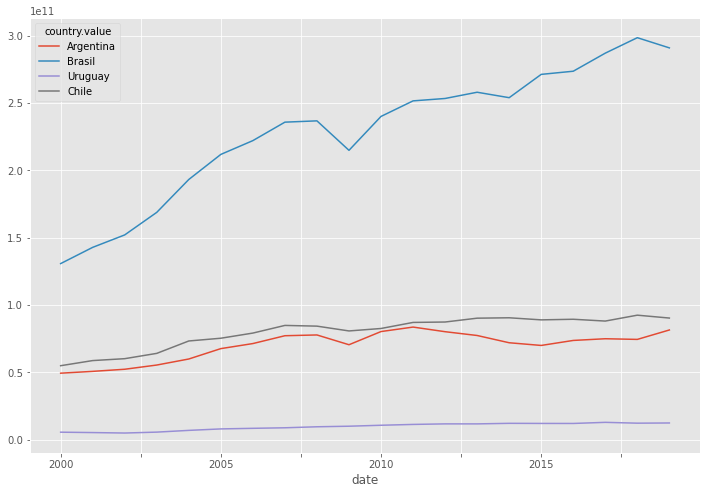

In [223]:
df_expo_series[['Argentina', 'Brasil', 'Uruguay', 'Chile']].plot()

Tal vez comparar la evolucion absoluta de exportaciones entre paises no tiene mucho sentido (tienen tamaños distintos). Podemos pedir mas de un indicador para esta muestra de paises, y calcular las exportaciones per capita.

Se pueden solicitar varios paises o varios indicadores, separando con ";".

In [241]:
expo_poblacion = requests.get(
    BASE_BM_API.format(
        pais='arg;bra;ury;chl', 
        indicador='SP.POP.TOTL;NE.EXP.GNFS.KD'
    ) + '&source=2'
).json()

df_expo_pobl = pd.json_normalize(expo_poblacion[1])

Necesitamos quedarnos con dos columnas que podamos dividir, y asi calcular nuestro propio indicador de exportaciones per capita.

In [242]:
df_expo_pobl_pivot = df_expo_pobl.pivot_table(
    index=['country.id', 'date'],
    columns='indicator.id',
    values='value'
)
df_expo_pobl_pivot

indicator.id     NE.EXP.GNFS.KD  SP.POP.TOTL
country.id date                             
AR         2000    4.928934e+10   36870787.0
           2001    5.064036e+10   37275652.0
           2002    5.220664e+10   37681749.0
           2003    5.533662e+10   38087868.0
           2004    5.982672e+10   38491972.0
...                         ...          ...
UY         2015    1.196635e+10    3412009.0
           2016    1.194755e+10    3424132.0
           2017    1.277231e+10    3436646.0
           2018    1.215714e+10    3449299.0
           2019    1.230619e+10    3461734.0

[80 rows x 2 columns]

In [243]:
df_expo_pobl_pivot['exportaciones_per_capita'] = df_expo_pobl_pivot['NE.EXP.GNFS.KD'] / df_expo_pobl_pivot['SP.POP.TOTL']

Ahora si! Podemos generar las series de tiempo por pais de exportaciones per capita, y graficarlas.

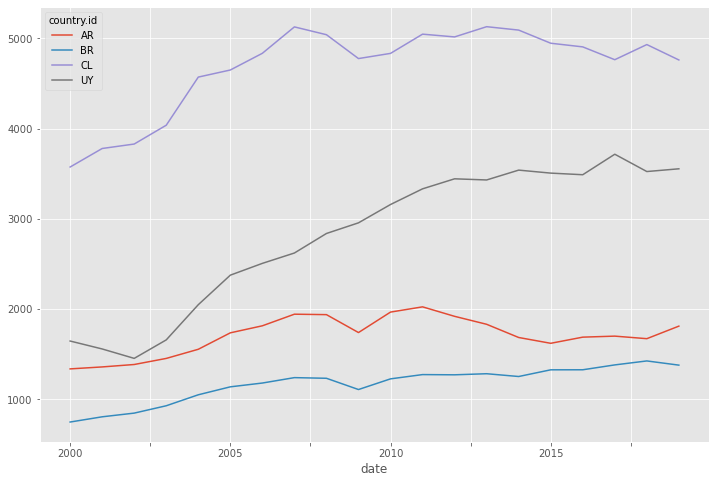

In [236]:
df_expo_pobl_pivot.pivot_table(
    index='date',
    columns='country.id',
    values='exportaciones_per_capita'
).plot()